In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# classifier we will use
from sklearn.tree import DecisionTreeClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import f1_score

# plotting
from plotting import plot_learning_curve, plot_validation_curve



# Detecting Spam with Decision Trees

In the last assignment we worked with the spam database. We are going to do the same thing in this assignment and we will practice with the correct tools this time around. 

In [2]:
## we are going to hardcode the column names, because this just makes it a little easier to use pandas.

names = ['word_freq_make:        ',
'word_freq_address:     ',
'word_freq_all:         ',
'word_freq_3d:          ',
'word_freq_our:         ',
'word_freq_over:        ',
'word_freq_remove:      ',
'word_freq_internet:    ',
'word_freq_order:       ',
'word_freq_mail:        ',
'word_freq_receive:     ',
'word_freq_will:        ',
'word_freq_people:      ',
'word_freq_report:      ',
'word_freq_addresses:   ',
'word_freq_free:        ',
'word_freq_business:    ',
'word_freq_email:       ',
'word_freq_you:         ',
'word_freq_credit:      ',
'word_freq_your:        ',
'word_freq_font:        ',
'word_freq_000:         ',
'word_freq_money:       ',
'word_freq_hp:          ',
'word_freq_hpl:         ',
'word_freq_george:      ',
'word_freq_650:         ',
'word_freq_lab:         ',
'word_freq_labs:        ',
'word_freq_telnet:      ',
'word_freq_857:         ',
'word_freq_data:        ',
'word_freq_415:         ',
'word_freq_85:          ',
'word_freq_technology:  ',
'word_freq_1999:        ',
'word_freq_parts:       ',
'word_freq_pm:          ',
'word_freq_direct:      ',
'word_freq_cs:          ',
'word_freq_meeting:     ',
'word_freq_original:    ',
'word_freq_project:     ',
'word_freq_re:          ',
'word_freq_edu:         ',
'word_freq_table:       ',
'word_freq_conference:  ',
'char_freq_;:           ',
'char_freq_(:           ',
'char_freq_[:           ',
'char_freq_!:           ',
'char_freq_$:           ',
'char_freq_#:           ',
'capital_run_length_average',
'capital_run_length_longest',
'capital_run_length_total: ',
'label']
          

In [14]:
## Load in the dataset here 
data = pd.read_csv('spambase/spambase.csv', names = names)
data.head()


,word_freq_make:,word_freq_address:,word_freq_all:,word_freq_3d:,word_freq_our:,word_freq_over:,word_freq_remove:,word_freq_internet:,word_freq_order:,word_freq_mail:,...,char_freq_;:,char_freq_(:,char_freq_[:,char_freq_!:,char_freq_$:,char_freq_#:,capital_run_length_average,capital_run_length_longest,capital_run_length_total:,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [22]:
X = data.drop('label', axis=1) # set axis=1 to drop the whole column. 
y = data.label


pandas.core.series.Series

In [23]:
# this time we will keep a bit more data for training and validation.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify = y)

## 1. Evaluate your classifier using 5 fold cross validation.

Do you see any variance in different runs?
Why do you think this is happening?


In [24]:
# create a default decision tree model
clf = DecisionTreeClassifier()

# create a stratifiedKfold cv object -- we want stratified to keep the class balance across folds
cv = StratifiedKFold(n_splits = 5)  # set it for 5 folds

# get the scores back using the helper function, make sure to pass a scoring function string - otherwise you default to accuracy
scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv, scoring='f1')

In [25]:
print(scores)

[0.88888889 0.88183422 0.88324873 0.90693739 0.89376054]


In [26]:
print(scores.mean())

0.8909339537793896


### Looking for variance in the runs

How much do the runs change over time? Let's run a for-loop and check.  In fact, that's exactly what shuffle split will do for us, so we can just run 100 iterations with 25% held out as validations - this will mimick 5-fold CV in the long run. 

In [27]:
sss_split = StratifiedShuffleSplit(n_splits = 200, test_size=0.25) # fill in the params
scores_sss = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=sss_split, scoring='f1')

In [28]:
# print at your own risk!
print (scores_sss)

[0.88140162 0.88033012 0.85106383 0.90136986 0.8824343  0.88858322
 0.88642659 0.88088643 0.88827586 0.86956522 0.88429752 0.87652646
 0.90495315 0.88493151 0.87301587 0.88888889 0.89415042 0.89795918
 0.90055249 0.88108108 0.86145405 0.89130435 0.88767123 0.88707483
 0.87619048 0.88978495 0.87858117 0.85909713 0.87464387 0.88010899
 0.87585266 0.88949523 0.89280868 0.89750693 0.87569061 0.88736264
 0.89568846 0.89580514 0.8696845  0.87517147 0.88055556 0.87150838
 0.89711934 0.87924016 0.87327824 0.87967914 0.88033012 0.89130435
 0.8840382  0.89636608 0.89823609 0.87101248 0.89757412 0.87704918
 0.87096774 0.88768606 0.8953168  0.8746594  0.89385475 0.88259109
 0.88268156 0.89501312 0.89750693 0.89189189 0.89784946 0.90787717
 0.88671329 0.89010989 0.88949523 0.89320388 0.86433566 0.89073306
 0.90482759 0.87915007 0.88461538 0.87569061 0.89740082 0.91083676
 0.87752355 0.8824343  0.87002653 0.89466484 0.88266667 0.87912088
 0.8879892  0.8739726  0.89693593 0.87248322 0.90148448 0.8834

In [29]:
scores_sss.mean()

0.8859294577530954

### Plotting a histogram of the runs

So we want to look for variance or variation in the runs. It's not easy to just look at a large list of scores and get any idea, so I will plot a histogram which should show us the distribution of results.

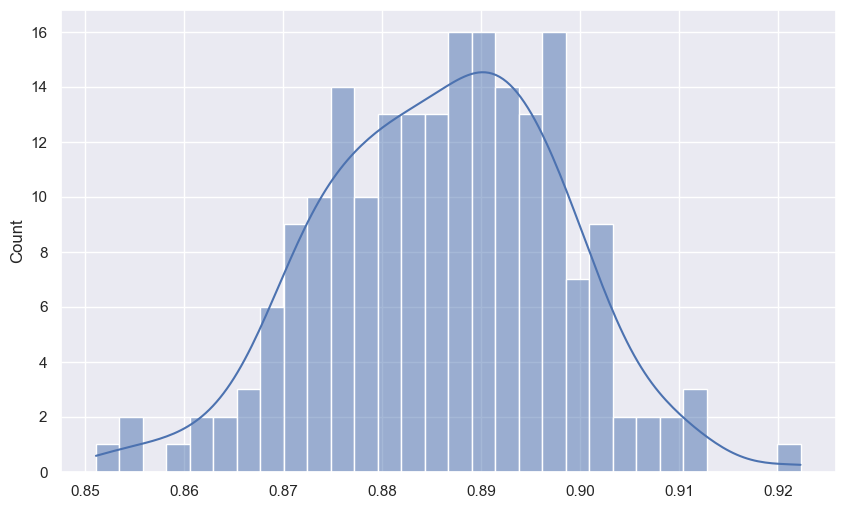

In [31]:
plt.figure(figsize=(10,6))
sns.histplot(scores_sss, kde=True, bins=30);  # go ahead and try different bins

### What does the histogram tell you?

What is the mean of the our model? What kind of variation can we expect?

#### Your answer below : 

## 2. Tune your models hyper-parameters with Gridsearch

Choose at least **3** parameters with **3** values each (total **9**) to search over
When you create your GridSearchCV object make sure to set the following

1. cv object - which CV do you want to use? This will be run for every experiment, so if you do 100 sss, then you get 100 experiments for every parameter setting! This will add up fast. So make sure to choose something reasonable.
2. scoring parameter - never forget this!

If you don't set the above, GridSearchCV will default to kfold=5 for the CV and accuracy for the scoring parameter.  kfold=5 isn't the worst (stratifiedkfold is better for us), but accuracy is really wrong for this dataset since it's unbalanced and a spam dataset.

Quiz Question: How many different trees will get made during your grid-search? You need to do the math on the number of splits per CV * number of combination from your grid-search.



In [32]:
# you need to setup a paramgrid.  I will give you one example

params = {'max_depth':[2,10,20,30], 'min_samples_leaf':[2,10,20,30], 'max_leaf_nodes':[2,10,20,30]} # will check max depth for those four parameters.

In [33]:
## make a gridsearch object and pass all the needed parameters.
grid = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=params,scoring='f1',cv=StratifiedKFold(n_splits=5))

In [34]:
# fit your grid-search! - it's an estimator so you fit it like a normal model.
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 10, 20, 30],
                         'max_leaf_nodes': [2, 10, 20, 30],
                         'min_samples_leaf': [2, 10, 20, 30]},
             scoring='f1')

## 2.1: Gridsearch Results 

1. What are the final parameters that were best?  (grid.best_params_)
2. What was your models best score? (grid.best_score_)
3. You can also print out the best estimator with grid.best_estimator_
4. Go ahead and put your grid results into a dataframe. 



In [ ]:
## DO WE NOT TEST THE PARAMETERS? It seems that we are determining the "best" parameters based on training results?

In [35]:
grid.best_params_

{'max_depth': 30, 'max_leaf_nodes': 30, 'min_samples_leaf': 2}

In [36]:
grid.best_score_

0.889287995778133

In [37]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=30, max_leaf_nodes=30, min_samples_leaf=2)

In [38]:
results = pd.DataFrame(grid.cv_results_)

In [39]:
results.head()
results['rank_test_score'].sort_values()

60     1
44     2
28     3
40     4
56     5
      ..
19    49
35    49
34    49
51    49
0     49
Name: rank_test_score, Length: 64, dtype: int32

In [40]:
print(results.iloc[60])
print('***************')
print(results.iloc[44])

mean_fit_time                                                      0.026591
std_fit_time                                                       0.002118
mean_score_time                                                    0.003319
std_score_time                                                     0.000381
param_max_depth                                                          30
param_max_leaf_nodes                                                     30
param_min_samples_leaf                                                    2
params                    {'max_depth': 30, 'max_leaf_nodes': 30, 'min_s...
split0_test_score                                                  0.904594
split1_test_score                                                  0.878843
split2_test_score                                                  0.880952
split3_test_score                                                  0.882051
split4_test_score                                                       0.9
mean_test_sc

## 3.  Randomized Search

#### Step 1, Distributions
In order to do randomized search we need to draw from a distribution.  This can be a bit confusing so I will first just plot some distributions for you, then it will be pretty clear which ones we want to draw from.

For decision trees most of the parameters we want to try out are integers. `min_samples_split`, `max_depth`, etc they are all integer numbers. So I will focus on distributions which draw integers

In [ ]:
#OK Whats happening?

In [42]:
import scipy

In [ ]:
sns.histplot(scipy.stats.norm(5, scale=2).rvs(1000), kde=True);

This is the gaussian or normal distribution.  In fact, we can't use it because it doesn't draw integers-- but I just wanted to show it to you! Well I suppose we could use it and then convert the output to integers.

In [ ]:
numbers = scipy.stats.norm(5, scale=2).rvs(1000)
sns.histplot(numbers.astype(int), kde=True); 

So we can use the gaussian and convert to integers, or we can draw from a uniform random distribution. That's plotted below. It basically says "pick a random number! Any random number!"

In [ ]:
sns.histplot(scipy.stats.randint(0,50).rvs(1000), kde=True);

So we need to choose a distribution for our grid-search. Based on what area we want to search we can choose uniform or int-converted gaussian. If we choose guassian we can "target" it by adjusting the mean and std, similarly we can set the range on the uniform distribution (the low and high ends).  You can decide what you want for your distribution. I will give you on example of how to setup the paramter grid for randomized search below.

In [ ]:
rand_params = { 'max_depth': scipy.stats.randint(2,100),}

## note that we don't say "how many" samples to draw in the param grid.
## We will do that below when we create the RandomizedSearchCV object

Note that we don't say "how many" samples to draw in the param grid. We will do that below when we create the RandomizedSearchCV object. You need to set the following
* estimator
* params
* n_iters (this decides how many times to sample from the distribution per setting)
* scoring
* cv

In [ ]:
rand_search = RandomizedSearchCV()

### Did you find different best parameters?
Which method do you like more?
What method do you think got better results?
Why? Why not?



### You answers here

## 4. Validate your classifier using

1. Learning Curve
2. Validation Curves (complexity graph)

Please plot at least 3 different validation curves for 3 different hyper-parameters than you can tune.

You can (and should) use the imported functions `plot_validation_curve` and `plot_learning_curve`. These functions are originally found on sklearn's site but I did modify them slightly for our use. You can check out the full code in plotting.py, which also contains links to the original source code.

## 5. Choose your best parameters:

Keep in mind that the random-search and grid-search will always maximize the validation score, even if it's in the area of overfitting. Looking at the validation curves you created, what you do think are the best parameter values?

Now create a tree model with this and fit it.

## 6. Looking at Feature Importances

Decision trees have a nice property that they can automatically sort your features by importance. This just naturally falls out from the gini coefficient or the information gain ratio (whichever one you used).  Therefore we can run a little code and actually see which features our model found to be the most important.


The code from Chris Albon below will help you do this, go ahead and run it.

In [ ]:
## https://chrisalbon.com/machine_learning/trees_and_forests/feature_importance/

importances = my_fav_clf.feature_importances_

indices = np.argsort(importances)[::-1]

# rearrange feature names so they match the sorted feature names
# I have my original names list of feature names, which corresponds to the features in the tree.
f_names = [names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right');


What is the most important feature that your model found? Does this surprise you, why or why not?

#### Your Answers:

## 6. Test your data.

Retrain your model using all the training data and using the hyper parameters you think are best. 
Then go ahead and test your model with the test data. Evaluate your model by testing on the test set. How did you do? What is your performance?

As always, ask yourself the question "If I was doing this professionally for a company, what other questions would I want answered?" Is this model ready to go??
